# End-to-End Image-to-Text Model: Donut (Document Understanding Transformer) 🍩

Donut is a combination of a swin encoder and a bart decoder. This means that it can generate text based on an image without needing any OCR. In this notebook, I show how you can use it to train a model for this competition. This is only the starting point, so I'm sure there is much room for improvement. Still, it is so cool that this one model can do everything necessary for this competition!

![donut diagram](https://raw.githubusercontent.com/clovaai/donut/master/misc/overview.png)

In [1]:
# You will have to restart the notebook after running this
# !pip install -U datasets transformers pyarrow polyleven -q

In [2]:
import os
import re
import json
from collections import Counter
from itertools import chain
from pathlib import Path
from typing import List, Dict, Union, Tuple, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from transformers import (
    DonutProcessor,
    VisionEncoderDecoderConfig,
    VisionEncoderDecoderModel,
    get_scheduler
)
from datasets import Dataset
from datasets import Image as ds_img
from polyleven import levenshtein # a faster version of levenshtein

/home/amir/miniconda3/envs/doc-ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = Path("../../data/benetech-making-graphs-accessible/train")

images_path = data_dir / "images"
train_json_files = list((data_dir / "annotations").glob("*.json"))


class CFG:

    # General
    debug = False
    num_proc = 2
    num_workers = 2
    gpus = 2

    # Data
    max_length = 1024
    image_height = 560
    image_width = 560

    # Training
    epochs = 2
    val_check_interval = 1.0  # how many times we want to validate during an epoch
    check_val_every_n_epoch = 1
    gradient_clip_val = 1.0
    lr = 3e-5
    lr_scheduler_type = "cosine"
    num_warmup_steps = 100
    seed = 42
    warmup_steps = 300  
    output_path = "output"
    log_steps = 200
    batch_size = 2
    use_wandb = False

# First step is to transform the given annotations into a format the model can work with

Since the predictions need to be in the form x1;x2;x3 and y1;y2;y3, let's make that the format we will generate. We also need to add special tokens to predict the chart type and separators to distinguish what is what.

Remember, Donut takes an image as input and will generate text as output.

In [4]:
# Let's add chart types as special tokens and a special BOS token

PROMPT_TOKEN = "<|PROMPT|>"
X_START = "<x_start>"
X_END = "<x_end>"
Y_START = "<y_start>"
Y_END = "<y_end>"

SEPARATOR_TOKENS = [
    PROMPT_TOKEN,
    X_START,
    X_END,
    Y_START,
    Y_END,
]

LINE_TOKEN =  "<line>" 
VERTICAL_BAR_TOKEN = "<vertical_bar>"
HORIZONTAL_BAR_TOKEN = "<horizontal_bar>"
SCATTER_TOKEN = "<scatter>"
DOT_TOKEN = "<dot>"

CHART_TYPE_TOKENS = [
    LINE_TOKEN,
    VERTICAL_BAR_TOKEN,
    HORIZONTAL_BAR_TOKEN,
    SCATTER_TOKEN,
    DOT_TOKEN,
]

new_tokens = SEPARATOR_TOKENS + CHART_TYPE_TOKENS

def round_float(value: Union[int, float, str]) -> Union[str, float]:
    """
    Convert a float value to a string with the specified number of decimal places. 
    If there is more than 1 digit in the integer, then we will truncate to 1 decimal.
    Otherwise, will truncate to 4 decimals.

    Args:
        value (int, float, str): The float value to convert

    Returns:
        str: The rounded float value as a string
    """
    if isinstance(value, float):
        value = str(value)

        if "." in value:
            integer, decimal = value.split(".")
            if abs(float(integer)) > 1:
                decimal = decimal[:1]
            else:
                decimal = decimal[:4]

            value = integer + "." + decimal
    return value


def is_nan(value: Union[int, float, str]) -> bool:
    """
    Check if a value is NaN (not a number).

    Args:
        value (int, float, str): The value to check

    Returns:
        bool: True if the value is NaN, False otherwise
    """
    return isinstance(value, float) and str(value) == "nan"


def get_gt_string_and_xy(filepath: Union[str, os.PathLike]) -> Dict[str, str]:
    """
    Get the ground truth string and x-y data from the given JSON file.

    Args:
        filepath (str): The path to the JSON file

    Returns:
        dict: A dictionary containing the ground truth string, x-y data, chart type, id, and source
    """
    filepath = Path(filepath)

    with open(filepath) as fp:
        data = json.load(fp)

    data_series = data["data-series"]

    all_x, all_y = [], []

    for d in data_series:
        x = d["x"]
        y = d["y"]

        x = round_float(x)
        y = round_float(y)

        # Ignore nan values
        if is_nan(x) or is_nan(y):
            continue

        all_x.append(x)
        all_y.append(y)
        
    
    chart_type = f"<{data['chart-type']}>"
    x_str = X_START + ";".join(list(map(str, all_x))) + X_END
    y_str = Y_START + ";".join(list(map(str, all_y))) + Y_END
    
    gt_string = PROMPT_TOKEN + chart_type + x_str + y_str

    return {
        "ground_truth": gt_string,
        "x": json.dumps(all_x),
        "y": json.dumps(all_y),
        "chart-type": data["chart-type"],
        "id": filepath.stem,
        "source": data["source"],
    }

In [5]:
get_gt_string_and_xy(data_dir / "annotations" / "000d269c8e26.json")

{'ground_truth': '<|PROMPT|><line><x_start>0;2;4;6;8;10;12<x_end><y_start>45.8;45.9;46.3;46.1;46.1;47.0;47.4<y_end>',
 'x': '["0", "2", "4", "6", "8", "10", "12"]',
 'y': '["45.8", "45.9", "46.3", "46.1", "46.1", "47.0", "47.4"]',
 'chart-type': 'line',
 'id': '000d269c8e26',
 'source': 'generated'}

# Creating the dataset

In [6]:
# This generator function will be used to create the Dataset object


def gen_data(files: List[Union[str, os.PathLike]]) -> Dict[str, str]:
    """
    This function takes a list of json files and returns a generator that yields a
    dictionary with the ground truth string and the path to the image.

    Args:
        files (list): A list of json files

    Returns:
        generator: A generator that yields a dictionary with the ground truth string and
            the path to the corresponding image.
    """

    for f in files:

        yield {
            **get_gt_string_and_xy(f),
            "image_path": str(images_path / f"{f.stem}.jpg"),
        }


ds = Dataset.from_generator(
    gen_data, gen_kwargs={"files": train_json_files}, num_proc=CFG.num_proc
)

# Checking image sizes

In [7]:
def add_image_sizes(examples: Dict[str, Union[str, os.PathLike]]) -> Dict[str, List[int]]:
    """
    This function takes a dictionary of examples and adds the width and height of the
    image to the dictionary. This is to be used with the `Dataset.map` function.

    Args:
        examples (dict): A dictionary of examples (from `map` function)

    Returns:
        dict: The dictionary with the width and height of the image added
    """

    sizes = [Image.open(x).size for x in examples["image_path"]]

    width, height = list(zip(*sizes))

    return {
        "width": list(width),
        "height": list(height),
    }


ds = ds.map(add_image_sizes, batched=True, num_proc=CFG.num_proc)

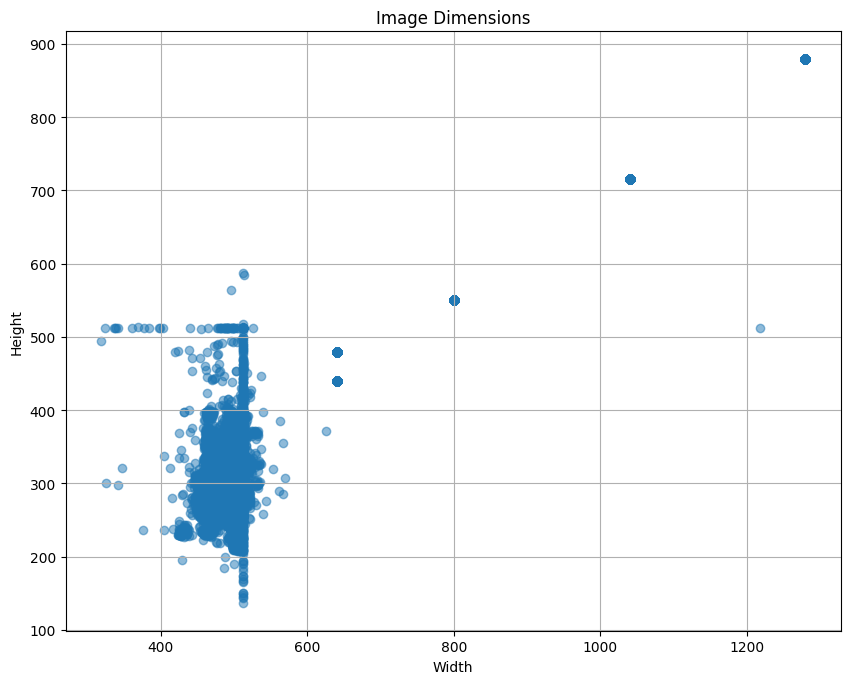

In [8]:
# Most fall within 560 x 560
plt.figure(figsize=(10, 10))

plt.scatter(x=ds["width"], y=ds["height"], marker="o", alpha=0.5)

# Add axis labels
plt.xlabel("Width")
plt.ylabel("Height")

# Add a title
plt.title("Image Dimensions")

# Add gridlines
plt.grid(True)

# Set aspect ratio to be equal
plt.gca().set_aspect("equal", adjustable="box")

# Show the plot
plt.show()

# Model configuration

Need to set:  

- image height
- image width
- max sequence length to generate

In [9]:
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = (CFG.image_height, CFG.image_width)
config.decoder.max_length = CFG.max_length

print(CFG.image_height, CFG.image_width, CFG.max_length)

560 560 1024


# Checking tokenizer for unknowns


In [10]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
processor.image_processor.size = {
    "height": CFG.image_height,
    "width": CFG.image_width,
}

In [11]:
def check_for_unk(examples: Dict[str, str]) -> Dict[str, List[str]]:
    """
    Check for unknown tokens in the given examples.

    This function takes a dictionary containing a list of ground truth texts and
    tokenizes them using the processor's tokenizer. It then checks for any unknown
    tokens in the tokenized text and returns a dictionary containing a list of the
    unknown tokens for each example.

    Args:
        examples (dict): A dictionary containing a list of ground truth texts. 
            Example: {"ground_truth": ["text1", "text2", ...]}

    Returns:
        dict: A dictionary containing a list of unknown tokens for each example. 
            Example: {"unk_tokens": [["unk1", "unk2"], [], ["unk3"], ...]}
    """

    texts = examples["ground_truth"]

    ids = processor.tokenizer(texts).input_ids
    tokens = [processor.tokenizer.tokenize(x, add_special_tokens=True) for x in texts]

    unk_tokens = []
    for example_ids, example_tokens in zip(ids, tokens):
        example_unk_tokens = []
        for i in range(len(example_ids)):
            if example_ids[i] == processor.tokenizer.unk_token_id:
                example_unk_tokens.append(example_tokens[i])

        unk_tokens.append(example_unk_tokens)

    return {"unk_tokens": unk_tokens}


unk = ds.map(check_for_unk, batched=True, num_proc=CFG.num_proc)

In [12]:
# Let's look at only the examples with unknown tokens
unk = unk.filter(lambda x: len(x["unk_tokens"]) > 0, num_proc=CFG.num_proc)

print(len(unk))

unk[0]

37712


{'ground_truth': '<|PROMPT|><line><x_start>Herkimer;Jefferson;Madison;Monroe;New York;Niagara;Oneida;Onondaga;Orange;Oswego;Putnam;Queens;Rensselaer;Richmond;Saratoga<x_end><y_start>9.8;12.1;10.0;10.0;11.1;11.2;10.1;11.1;10.2;13.0;10.4;14.8;12.3;14.7;10.7<y_end>',
 'x': '["Herkimer", "Jefferson", "Madison", "Monroe", "New York", "Niagara", "Oneida", "Onondaga", "Orange", "Oswego", "Putnam", "Queens", "Rensselaer", "Richmond", "Saratoga"]',
 'y': '["9.8", "12.1", "10.0", "10.0", "11.1", "11.2", "10.1", "11.1", "10.2", "13.0", "10.4", "14.8", "12.3", "14.7", "10.7"]',
 'chart-type': 'line',
 'id': '0f28aa27d064',
 'source': 'generated',
 'image_path': '../../data/benetech-making-graphs-accessible/train/images/0f28aa27d064.jpg',
 'width': 487,
 'height': 332,
 'unk_tokens': ['1', '1', '1', '1']}

In [13]:
# Let's count which tokens show up most often as unknowns
all_unk_tokens = [x for y in unk["unk_tokens"] for x in y]

Counter(all_unk_tokens)

Counter({'1': 80183, 'ދ': 1})

It seems that the donut tokenizer doesn't contain "1" which will result in many unknown tokens in the ground truth string. There is "_1" (space in front of 1) and "01", "11", "21", "31", "41" etc. But if there is a "0.1" or ">1" then the 1 will turn into an unknown token.

I'll handle this in the `preprocess` function.

In [14]:
example_str = "0.1 1 1990"

temp_ids = processor.tokenizer(example_str).input_ids
print("ids:", temp_ids)
print("tokenized:", processor.tokenizer.tokenize(example_str))
print("decoded:", processor.tokenizer.decode(temp_ids))
print("unk id:", processor.tokenizer.unk_token_id)

# Adding these tokens should mean that there should be very few unknown tokens
num_added = processor.tokenizer.add_tokens(["<one>"] + new_tokens)
print(num_added, "tokens added")

config.pad_token_id = processor.tokenizer.pad_token_id
config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids([PROMPT_TOKEN])[0]

ids: [0, 50891, 39539, 3, 1314, 4314, 2]
tokenized: ['▁0', '.', '1', '▁1', '▁1990']
decoded: <s> 0.<unk> 1 1990</s>
unk id: 3
11 tokens added


# Preprocessing function to get pixel values and input_ids

When ever the `_getitem__` function is called for the dataset, it will run this function.

In [15]:
from functools import partial

one_token_id = processor.tokenizer("<one>", add_special_tokens=False).input_ids[0]
unk_token_id = processor.tokenizer.unk_token_id


def replace_unk_tokens_with_one(example_ids: List[int], example_tokens: List[str], one_token_id:int, unk_token_id:int) -> List[int]:
    """
    Replace unknown tokens that represent "1" with the correct token id.

    Args:
        example_ids (list): List of token ids for a given example
        example_tokens (list): List of tokens for the same given example
        one_token_id (int): Token id for the "<one>" token
        unk_token_id (int): Token id for the unknown token

    Returns:
        list: The updated list of token ids with the correct token id for "1"
    """
    
    temp_ids = []
    for id_, token in zip(example_ids, example_tokens):
        if id_ == unk_token_id and token == "1":
            id_ = one_token_id
        temp_ids.append(id_)
    return temp_ids


def preprocess(examples: Dict[str, str], processor: DonutProcessor, CFG: CFG) -> Dict[str, Union[torch.Tensor, List[int], List[str]]]:
    """
    Preprocess the given examples.

    This function processes the input examples by tokenizing the texts, replacing
    any unknown tokens that represent "1" with the correct token id, and loading
    the images.

    Args:
        examples (dict): A dictionary containing ground truth texts, image paths, and ids
        processor: An object responsible for tokenizing texts and processing images
        CFG: A configuration object containing settings and hyperparameters

    Returns:
        dict: A dictionary containing preprocessed images, token ids, and ids
    """
    
    pixel_values = []

    texts = examples["ground_truth"]

    ids = processor.tokenizer(
        texts,
        add_special_tokens=False,
        max_length=CFG.max_length,
        padding=True,
        truncation=True,
    ).input_ids

    if isinstance(texts, str):
        texts = [texts]

    tokens = [processor.tokenizer.tokenize(text, add_special_tokens=False) for text in texts]
    
    one_token_id = processor.tokenizer("<one>", add_special_tokens=False).input_ids[0]
    unk_token_id = processor.tokenizer.unk_token_id
    
    final_ids = [
        replace_unk_tokens_with_one(example_ids, example_tokens, one_token_id, unk_token_id)
        for example_ids, example_tokens in zip(ids, tokens)
    ]

    for sample in examples["image_path"]:
        pixel_values.append(processor(sample, random_padding=True).pixel_values)

    return {
        "pixel_values": torch.tensor(np.vstack(pixel_values)),
        "input_ids": final_ids,
        "id": examples["id"],
    }


image_ds = ds.cast_column("image_path", ds_img())
image_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

In [16]:
sample = image_ds[[0, 1, 2]]

print(sample["pixel_values"].shape)
print(processor.decode(sample["input_ids"][2]))
print(len(sample["input_ids"][2]))
print(processor.tokenizer.convert_ids_to_tokens(sample["input_ids"][2]))

torch.Size([3, 3, 560, 560])
<|PROMPT|><vertical_bar><x_start> 2;3;5;6;8;9;10;12;13;14;15;16;17;18;19<x_end><y_start> 11.1;20.2;15.<one>;13.0;13.0;21.1;17.<one>;17.<one>;19.2;17.<one>;16.<one>;<one>2.1;18.0;<one>2.1;23.1<y_end>
89
['<|PROMPT|>', '<vertical_bar>', '<x_start>', '▁2', ';', '3', ';', '5', ';', '6', ';', '8', ';', '9', ';', '10', ';', '12', ';', '13', ';', '14', ';', '15', ';', '16', ';', '17', ';', '18', ';', '19', '<x_end>', '<y_start>', '▁1', '1.1', ';', '20', '.', '2', ';', '15', '.', '<one>', ';', '13', '.', '0', ';', '13', '.', '0', ';', '2', '1.1', ';', '17', '.', '<one>', ';', '17', '.', '<one>', ';', '19', '.', '2', ';', '17', '.', '<one>', ';', '16', '.', '<one>', ';', '<one>', '2.1', ';', '18', '.', '0', ';', '<one>', '2.1', ';', '2', '3.1', '<y_end>']


# Creating splits


Basic split: break extracted into folds, all generated and some extracted into train. Only extracted in validation.

In [17]:
# separate by extracted and generated

extracted_ds = ds.filter(lambda x: x["source"] == "extracted", num_proc=CFG.num_proc)
generated_ds = ds.filter(lambda x: x["source"] == "generated", num_proc=CFG.num_proc)

chart_types = extracted_ds["chart-type"]

print(Counter(chart_types))

skf = StratifiedKFold(n_splits=4)

fold_idxs = []

for _, val_idxs in skf.split(chart_types, y=chart_types):
    fold_idxs.append(val_idxs)


for n, idxs in enumerate(fold_idxs):
    print(Counter([chart_types[i] for i in idxs]))
    if n > 3:
        break

Counter({'vertical_bar': 457, 'line': 423, 'scatter': 165, 'horizontal_bar': 73})
Counter({'vertical_bar': 114, 'line': 105, 'scatter': 42, 'horizontal_bar': 19})
Counter({'vertical_bar': 115, 'line': 106, 'scatter': 41, 'horizontal_bar': 18})
Counter({'vertical_bar': 114, 'line': 106, 'scatter': 41, 'horizontal_bar': 18})
Counter({'vertical_bar': 114, 'line': 106, 'scatter': 41, 'horizontal_bar': 18})


In [18]:
# Combine generated and some of the extracted examples into the train set

from datasets import concatenate_datasets

fold = 0

train_extracted = extracted_ds.select(
    list(chain(*[x for i, x in enumerate(fold_idxs) if i != fold]))
)
train_ds = concatenate_datasets([train_extracted, generated_ds])
train_ds = train_ds.cast_column("image_path", ds_img())
train_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

# Creat validation set from only extracted examples

val_gt_ds = extracted_ds.select(fold_idxs[fold])
val_ds = val_gt_ds.cast_column("image_path", ds_img())
val_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

gt_chart_type = val_gt_ds["chart-type"]
gt_x = [json.loads(_) for _ in val_gt_ds["x"]]
gt_y = [json.loads(_) for _ in val_gt_ds["y"]]
gt_ids = val_gt_ds["id"]

i = 0
print(gt_chart_type[i])
print(gt_x[i])
print(gt_y[i])
print(gt_ids[i])
print(Counter(gt_chart_type))

scatter
[15, 260, 382, 526, 608, 2801]
[74, 81, 68, 61, 71, 58]
32ae225ae9ca
Counter({'vertical_bar': 114, 'line': 105, 'scatter': 42, 'horizontal_bar': 19})


# Collate function to make sure the ids are all the same length in a batch

In [19]:
pad_token_id = processor.tokenizer.pad_token_id


def collate_fn(samples: List[Dict[str, Union[torch.Tensor, List[int], str]]]) -> Dict[str, Union[torch.Tensor, List[str]]]:
    """
    Custom collate function for DataLoader.

    This function takes a list of samples and combines them into a batch with
    properly padded input_ids.

    Args:
        samples (List[Dict[str, Union[torch.Tensor, List[int], str]]]): 
            A list of samples, where each sample is a dictionary containing
            "pixel_values" (torch.Tensor), "input_ids" (List[int]), and "id" (str).

    Returns:
        Dict[str, Union[torch.Tensor, List[str]]]: 
            A dictionary containing the combined pixel values, padded input_ids, and ids.
    """

    batch = {}

    batch["pixel_values"] = torch.stack([x["pixel_values"] for x in samples])

    max_length = max([len(x["input_ids"]) for x in samples])

    # Make a multiple of 8 to efficiently use the tensor cores
    if max_length % 8 != 0:
        max_length = (max_length // 8 + 1) * 8

    input_ids = [
        x["input_ids"] + [pad_token_id] * (max_length - len(x["input_ids"]))
        for x in samples
    ]

    labels = torch.tensor(input_ids)
    labels[labels == pad_token_id] = -100 # ignore loss on padding tokens
    batch["labels"] = labels
    
    batch["id"] = [x["id"] for x in samples]

    return batch


# Dataloaders

Validation uses generation so it is very slow. That's why I only use a small fraction of the examples.

In [20]:
if CFG.debug:
    train_ds = train_ds.select(range(100))
    val_ds = val_ds.select(range(100))

train_dataloader = DataLoader(
    train_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=CFG.num_workers,
)
val_dataloader = DataLoader(
    val_ds,
    batch_size=CFG.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=CFG.num_workers,
)

num_training_steps = len(train_dataloader) * CFG.epochs // CFG.gpus

batch = next(iter(train_dataloader))

batch.keys(), [(k, v.shape) for k, v in batch.items() if k != "id"]

(dict_keys(['pixel_values', 'labels', 'id']),
 [('pixel_values', torch.Size([2, 3, 560, 560])),
  ('labels', torch.Size([2, 120]))])

# Functions to calculate metrics

In [21]:
def rmse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the Root Mean Square Error (RMSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The Root Mean Square Error.
    """
    return np.sqrt(np.mean(np.square(np.subtract(y_true, y_pred))))


def sigmoid(x: float) -> float:
    """
    Calculate the sigmoid function for the given value.

    Args:
        x (float): The input value.

    Returns:
        float: The result of the sigmoid function.
    """
    return 2 - 2 / (1 + np.exp(-x))


def normalized_rmse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the normalized Root Mean Square Error (RMSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The normalized Root Mean Square Error.
    """
    numerator = rmse(y_true, y_pred)
    denominator = rmse(y_true, np.mean(y_true))

    # https://www.kaggle.com/competitions/benetech-making-graphs-accessible/discussion/396947
    if denominator == 0:
        if numerator == 0:
            return 1.0
        return 0.0

    return sigmoid(numerator / denominator)


def normalized_levenshtein_score(y_true: List[str], y_pred: List[str]) -> float:
    """
    Calculate the normalized Levenshtein distance between two lists of strings.

    Args:
        y_true (List[str]): The true values.
        y_pred (List[str]): The predicted values.

    Returns:
        float: The normalized Levenshtein distance.
    """
    total_distance = np.sum([levenshtein(yt, yp) for yt, yp in zip(y_true, y_pred)])
    length_sum = np.sum([len(yt) for yt in y_true])
    return sigmoid(total_distance / length_sum)


def score_series(
    y_true: List[Union[float, str]], y_pred: List[Union[float, str]]
) -> float:
    """
    Calculate the score for a series of true and predicted values.

    Args:
        y_true (List[Union[float, str]]): The true values.
        y_pred (List[Union[float, str]]): The predicted values.

    Returns:
        float: The score for the series.
    """
    if len(y_true) != len(y_pred):
        return 0.0
    if isinstance(y_true[0], str):
        return normalized_levenshtein_score(y_true, y_pred)
    else:
        # Since this is a generative model, there is a chance it doesn't produce a float.
        # In that case, we return 0.0.
        try:
            return normalized_rmse(y_true, list(map(float, y_pred)))
        except:
            return 0.0


def benetech_score(ground_truth: pd.DataFrame, predictions: pd.DataFrame) -> float:
    """Evaluate predictions using the metric from the Benetech - Making Graphs Accessible.

    Parameters
    ----------
    ground_truth: pd.DataFrame
        Has columns `[data_series, chart_type]` and an index `id`. Values in `data_series`
        should be either arrays of floats or arrays of strings.

    predictions: pd.DataFrame
    """
    if not ground_truth.index.equals(predictions.index):
        raise ValueError(
            "Must have exactly one prediction for each ground-truth instance."
        )
    if not ground_truth.columns.equals(predictions.columns):
        raise ValueError(f"Predictions must have columns: {ground_truth.columns}.")
    pairs = zip(
        ground_truth.itertuples(index=False), predictions.itertuples(index=False)
    )
    scores = []
    for (gt_series, gt_type), (pred_series, pred_type) in pairs:
        if gt_type != pred_type:  # Check chart_type condition
            scores.append(0.0)
        else:  # Score with RMSE or Levenshtein as appropriate
            scores.append(score_series(gt_series, pred_series))

    ground_truth["score"] = scores

    grouped = ground_truth.groupby("chart_type", as_index=False)["score"].mean()

    chart_type2score = {
        chart_type: score
        for chart_type, score in zip(grouped["chart_type"], grouped["score"])
    }

    return np.mean(scores), chart_type2score


def string2triplet(pred_string: str) -> Tuple[str, List[str], List[str]]:
    """
    Convert a prediction string to a triplet of chart type, x values, and y values.

    Args:
        pred_string (str): The prediction string.

    Returns:
        Tuple[str, List[str], List[str]]: A triplet of chart type, x values, and y values.
    """
    
    chart_type = "line"
    for tok in CHART_TYPE_TOKENS:
        if tok in pred_string:
            chart_type = tok.strip("<>")

    pred_string = re.sub(r"<one>", "1", pred_string)

    x = pred_string.split(X_START)[1].split(X_END)[0].split(";")
    y = pred_string.split(Y_START)[1].split(Y_END)[0].split(";")

    if len(x) == 0 or len(y) == 0:
        return chart_type, [], []

    min_length = min(len(x), len(y))

    x = x[:min_length]
    y = y[:min_length]

    return chart_type, x, y


def validation_metrics(val_outputs: List[str], val_ids: List[str], gt_df: pd.DataFrame) -> Dict[str, float]:
    """
    Calculate validation metrics for a set of outputs, ids, and ground truth dataframe.

    Args:
        val_outputs (List[str]): A list of validation outputs.
        val_ids (List[str]): A list of validation ids.
        gt_df (pd.DataFrame): The ground truth dataframe.

    Returns:
        Dict[str, float]: A dictionary containing the validation scores.
    """
    pred_triplets = []

    for example_output in val_outputs:

        if not all([x in example_output for x in [X_START, X_END, Y_START, Y_END]]):
            pred_triplets.append(("line", [], []))
        else:
            pred_triplets.append(string2triplet(example_output))

    pred_df = pd.DataFrame(
        index=[f"{id_}_x" for id_ in val_ids] + [f"{id_}_y" for id_ in val_ids],
        data={
            "data_series": [x[1] for x in pred_triplets]
            + [x[2] for x in pred_triplets],
            "chart_type": [x[0] for x in pred_triplets] * 2,
        },
    )

    overall_score, chart_type2score = benetech_score(
        gt_df.loc[pred_df.index.values], pred_df
    )

    return {
        "val_score": overall_score,
        **{f"{k}_score": v for k, v in chart_type2score.items()},
    }


# Lightning Module

It will use generation for validation which can be very slow. If you want to utilize the two GPUs on Kaggle, you should probably not run it in a notebook because DDP gets funky when doing that.

In [22]:
import pytorch_lightning as pl
from transformers import PreTrainedTokenizerBase, PreTrainedModel
from typing import Dict, List, Any
import torch
import pandas as pd

class DonutModelPLModule(pl.LightningModule):
    def __init__(
        self,
        processor: PreTrainedTokenizerBase,
        model: PreTrainedModel,
        gt_df: pd.DataFrame,
        num_training_steps: int
    ):
        """
        A PyTorch Lightning module for the DonutModel.

        Args:
            processor (PreTrainedTokenizerBase): The tokenizer/processor for the model.
            model (PreTrainedModel): The pretrained model.
            gt_df (pd.DataFrame): The ground truth dataframe.
            num_training_steps (int): The number of training steps.
        """
        super().__init__()
        self.processor = processor
        self.model = model
        self.gt_df = gt_df
        self.num_training_steps = num_training_steps

        # Initialize validation outputs and IDs
        self.val_outputs = []
        self.val_ids = []

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int, dataloader_idx: int = 0) -> None:
        pixel_values = batch["pixel_values"]
        batch_size = pixel_values.shape[0]

        # Prepare decoder input IDs
        decoder_input_ids = torch.full(
            (batch_size, 1),
            self.model.config.decoder_start_token_id,
            device=self.device,
        )

        # Generate outputs
        outputs = self.model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=CFG.max_length,
            early_stopping=True,
            pad_token_id=self.processor.tokenizer.pad_token_id,
            eos_token_id=self.processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            top_k=1,
            bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

        # Decode and store outputs and IDs
        decoded_sequences = self.processor.tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)
        self.val_outputs.extend(decoded_sequences)
        self.val_ids.extend(batch["id"])

    def on_validation_start(self) -> None:
        self.val_outputs = []
        self.val_ids = []

    def on_validation_epoch_end(self) -> None:
        metrics = validation_metrics(self.val_outputs, self.val_ids, self.gt_df)
        print("\n", metrics)
        self.log_dict(metrics)
        self.val_outputs = []
        self.val_ids = []

    def configure_optimizers(self) -> torch.optim.Optimizer:
        optimizer = torch.optim.Adam(self.parameters(), lr=CFG.lr)
        return optimizer

# Create model and ground truth dataframe

In [23]:
gt_chart_type = val_gt_ds["chart-type"]
gt_x = [json.loads(_) for _ in val_gt_ds["x"]]
gt_y = [json.loads(_) for _ in val_gt_ds["y"]]
gt_ids = val_gt_ds["id"]

index = [f"{id_}_x" for id_ in gt_ids] + [f"{id_}_y" for id_ in gt_ids]
gt_df = pd.DataFrame(
    index=index,
    data={
        "data_series": gt_x + gt_y,
        "chart_type": gt_chart_type * 2,
    },
)


model = VisionEncoderDecoderModel.from_pretrained(
    "naver-clova-ix/donut-base", config=config
)
model.decoder.resize_token_embeddings(len(processor.tokenizer))
model_module = DonutModelPLModule(processor, model, gt_df, num_training_steps)

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    560,
    560
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.46.3",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_f

# Train!

In [24]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

checkpoint_cb = ModelCheckpoint(CFG.output_path)

loggers = []
if CFG.use_wandb:
    import wandb
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    key = user_secrets.get_secret("wandb")
    wandb.login(key=key)
    
    loggers.append(WandbLogger(project="benetech"))


# 1. Update Trainer Precision
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=CFG.epochs,
    val_check_interval=CFG.val_check_interval,
    check_val_every_n_epoch=CFG.check_val_every_n_epoch,
    gradient_clip_val=CFG.gradient_clip_val,
    precision="16-mixed",  # Updated precision
    num_sanity_val_steps=5,
    callbacks=[checkpoint_cb], 
    logger=loggers
)

trainer.fit(model_module, train_dataloaders=train_dataloader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/home/amir/miniconda3/envs/doc-ai/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params | Mode
-----------------------------------------------------------
0 | model |

Epoch 0:   0%|          | 1/30149 [00:00<4:25:56,  1.89it/s, train_loss_step=8.180]

/home/amir/miniconda3/envs/doc-ai/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1: 100%|██████████| 30149/30149 [50:03<00:00, 10.04it/s, train_loss_step=0.646, train_loss_epoch=0.778]   

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 30149/30149 [50:05<00:00, 10.03it/s, train_loss_step=0.646, train_loss_epoch=0.778]


I interrupted the run because I was impatient

In [25]:
trainer.validate(model_module, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0:   0%|          | 0/140 [00:00<?, ?it/s]

/home/amir/miniconda3/envs/doc-ai/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/home/amir/miniconda3/envs/doc-ai/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Validation DataLoader 0: 100%|██████████| 140/140 [02:35<00:00,  0.90it/s]
 {'val_score': np.float64(0.38899295848575033), 'horizontal_bar_score': 0.0, 'line_score': 0.4388653663747004, 'scatter_score': 0.06163985955942314, 'vertical_bar_score': 0.528493778992726}
Validation DataLoader 0: 100%|██████████| 140/140 [02:35<00:00,  0.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  horizontal_bar_score              0.0
       line_score           0.4388653635978699
      scatter_score         0.06163986027240753
        val_score           0.38899296522140503
   vertical_bar_score       0.5284937620162964
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_score': 0.38899296522140503,
  'horizontal_bar_score': 0.0,
  'line_score': 0.4388653635978699,
  'scatter_score': 0.06163986027240753,
  'vertical_bar_score': 0.5284937620162964}]

In [26]:
# Could also use the checkpoint callback
model_module.model.save_pretrained(CFG.output_path)
model_module.processor.save_pretrained(CFG.output_path)

[]